In [1]:
import torch

from dataset.processor import Processor
from model.model import VisionLanguageModel
from utils.config import DatasetConfig, ExperimentConfig, ImageEncoderConfig

import matplotlib.pyplot as plt
import numpy as np

/Users/linus/Developer/master-thesis/master-thesis/.env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/linus/Developer/master-thesis/master-thesis/.env/lib/python3.12/site-packages/albumentations/check_version.py:107: UserWarning: Error fetching version info <urlopen error [Errno 8] nodename nor servname provided, or not known>
  data = fetch_version_info()


Please install pyav to use video processing functions.
OpenCLIP not installed


In [2]:
# Example config (adapt as needed)
config = ExperimentConfig(
    model_name="lmms-lab/llava-onevision-qwen2-0.5b-si",
    batch_size=1,
    device="cpu",
    image_token="<image>",
    image_encoder=ImageEncoderConfig(
        name="siglip",
        image_size=[384, 384],
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5],
        num_image_tokens=729,
        interpolation=2,
    ),
    add_special_tokens=True,
    val_dataset=DatasetConfig(
        name="coco_val",
        data_dir="../data/coco/images/val2017",
        annotations_dir="../data/coco/annotations/instances_val2017.json",
    ),
    num_workers=0,

    add_detr_layers=True,
    feedback_detr_to_llm=True,
    detr_loss=True,
    detr_type="full_detr",
    num_query_tokens=60, # 20, 60

    num_coordinate_bins=200, # 100, 200
    temperature=0.3,
    lora=True, # True, False
    lora_rank=256,
    lora_alpha=512,
    lora_dropout=0.05,

    # ...add other config fields as needed
)


# Initialize processor and model
processor = Processor.from_config(config, add_special_tokens=config.add_special_tokens)
model = VisionLanguageModel(
    config=config,
    image_token_index=processor.image_token_index,
    num_new_tokens=(len(processor.special_tokens) if config.add_special_tokens else 0),
    tokenizer_size=processor.loaded_tokenizer_len,
    initializers=(
        processor.special_tokens_initializer if config.add_special_tokens else None
    ),
    do_init=config.add_special_tokens,
    query_tokens_id=(
        processor.tokenizer.encode("<query00/>")
        if config.num_query_tokens > 0
        else None
    ),
)

model.eval()

You are using a model of type llava to instantiate a model of type llava_qwen. This is not supported for all configurations of models and can yield errors.
Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Loading vision tower: google/siglip-so400m-patch14-384


Tokenizer vocab size 151647 does not match model vocab size 151936. Resizing model embeddings to match tokenizer size.


trainable params: 17,301,504 || all params: 513,171,968 || trainable%: 3.3715


VisionLanguageModel(
  (model): PeftModelForCausalLM(
    (base_model): LoraModel(
      (model): LlavaQwenForCausalLM(
        (model): LlavaQwenModel(
          (embed_tokens): PartiallyFrozenEmbedding(
            (frozen_embedding): Embedding(151647, 896)
            (trainable_embedding): Embedding(468, 896)
          )
          (layers): ModuleList(
            (0-23): 24 x Qwen2DecoderLayer(
              (self_attn): Qwen2Attention(
                (q_proj): lora.Linear(
                  (base_layer): Linear(in_features=896, out_features=896, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.05, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=896, out_features=256, bias=False)
                  )
                  (lora_B): ModuleDict(
                    (default): Linear(in_features=256, out_features=896, bias=False)
                  )
            

In [3]:
# Load checkpoint if available
checkpoint_path = '../checkpoints/last_model_electric-brook-344.pt' # with lora
#checkpoint_path = "../checkpoints/last_model_eager-shape-323.pt" # without lora
checkpoint = torch.load(checkpoint_path, map_location=config.device)
missing_keys, unexpected_keys = model.load_state_dict(checkpoint['model_state_dict'])
print(f"Missing keys: {missing_keys}")
print(f"Unexpected keys: {unexpected_keys}")
model.eval()

Missing keys: ['base_model.model.model.embed_tokens.frozen_embedding.weight', 'base_model.model.model.embed_tokens.trainable_embedding.weight', 'base_model.model.lm_head.frozen_lm_head.weight', 'base_model.model.lm_head.trainable_lm_head.weight']
Unexpected keys: ['base_model.model.model.embed_tokens.weight', 'base_model.model.lm_head.weight']


VisionLanguageModel(
  (model): PeftModelForCausalLM(
    (base_model): LoraModel(
      (model): LlavaQwenForCausalLM(
        (model): LlavaQwenModel(
          (embed_tokens): PartiallyFrozenEmbedding(
            (frozen_embedding): Embedding(151647, 896)
            (trainable_embedding): Embedding(468, 896)
          )
          (layers): ModuleList(
            (0-23): 24 x Qwen2DecoderLayer(
              (self_attn): Qwen2Attention(
                (q_proj): lora.Linear(
                  (base_layer): Linear(in_features=896, out_features=896, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.05, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=896, out_features=256, bias=False)
                  )
                  (lora_B): ModuleDict(
                    (default): Linear(in_features=256, out_features=896, bias=False)
                  )
            

In [4]:
from utils.train_utils import build_val_dataloader

dataloader = build_val_dataloader(
    config=config,
    processor=processor,
    subset_size=10,  # For testing, use a single sample
    use_random_subset=True,  # Use the first sample for testing
)

inputs = next(iter(dataloader))

# Move tensors to device
inputs = {
    k: v.to(config.device) if torch.is_tensor(v) else v for k, v in inputs.items()
}


loading annotations into memory...
Done (t=0.20s)
creating index...
index created!


In [5]:
from utils.train_metrics import TrainMetrics

metrics = TrainMetrics(device=config.device, download_nltk=True)

[nltk_data] Error loading wordnet: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>
[nltk_data] Error loading omw-1.4: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>
[nltk_data] Error loading punkt_tab: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>


In [6]:
# Visualize Results
index_to_cat_name = dataloader.dataset.dataset.index_to_cat_name
# Show image with predicted bounding boxes, implement function here
def show_img_with_bbox(image, predicted_boxes, target_boxes=None, title=None):
    # Add this function somewhere (e.g., in your processor or utils)
    def unnormalize(img, mean, std):
        """
        img: torch.Tensor (C, H, W), normalized
        mean, std: lists of 3 floats
        Returns: numpy array (H, W, C), uint8
        """
        img = img.clone().cpu()
        for c in range(3):
            img[c] = img[c] * std[c] + mean[c]
        img = img.permute(1, 2, 0).numpy()  # (H, W, C)
        img = (img * 255).clip(0, 255).astype("uint8")
        return img

    if isinstance(image, torch.Tensor):
        img = unnormalize(image, config.image_encoder.mean, config.image_encoder.std)
    else:
        img = np.array(image)

    plt.imshow(img)
    plt.axis("off")

    for prediction in predicted_boxes:
        boxes, labels, scores = prediction.values()

        for box, label, score in zip(boxes, labels, scores):
            x1, y1, x2, y2 = box
            rect = plt.Rectangle(
                (x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor="r", facecolor="none"
            )
            plt.gca().add_patch(rect)
            plt.text(
                x1,
                y1,
                f"{index_to_cat_name[label.item()]} {score:.2f}",
                color="white",
                fontsize=8,
                bbox=dict(facecolor="red", alpha=0.5),
            )
    if target_boxes:
        for target in target_boxes:
            boxes, labels = target.values()
            for box, label in zip(boxes, labels):
                x1, y1, x2, y2 = box
                rect = plt.Rectangle(
                    (x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor="g", facecolor="none"
                )
                plt.gca().add_patch(rect)
                plt.text(
                    x1,
                    y1,
                    f"{index_to_cat_name[label.item()]}",
                    color="white",
                    fontsize=8,
                    bbox=dict(facecolor="green", alpha=0.5),
                )

    if title:
        plt.title(title)

    plt.show()
    #plt.savefig("inference/output.png", bbox_inches='tight', pad_inches=0.1)

<class 'peft.peft_model.PeftModelForCausalLM'>


Generated text: ['<annotation><object><class>surfboard</class><bbox><x000/><y079/><x173/><y137/></bbox></object></annotation>']


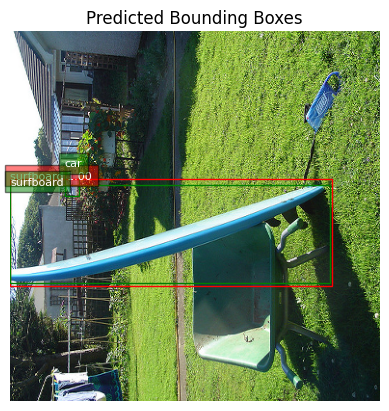

Generated text: ['<annotation><object><class>person</class><bbox><x010/><y036/><x109/><y195/></bbox></object></annotation>']


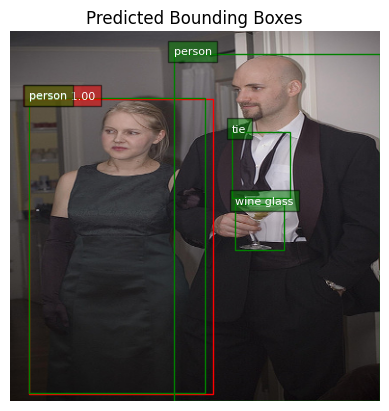

Error processing item 0 in batch: No objects found in XML


Generated text: ['<annotation></annotation>']


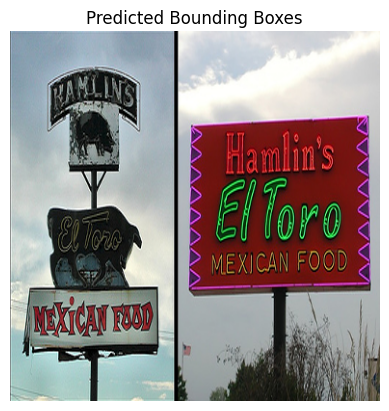

Generated text: ['<annotation><object><class>sheep</class><bbox><x000/><y075/><x073/><y133/></bbox></object><object><class>sheep</class><bbox><x075/><y077/><x151/><y139/></bbox></object><object><class>sheep</class><bbox><x003/><y080/><x026/><y104/></bbox></object><object><class>sheep</class><bbox><x048/><y079/><x069/><y118/></bbox></object><object><class>sheep</class><bbox><x132/><y081/><x198/><y135/></bbox></object><object><class>sheep</class><bbox><x068/><y083/><x111/><y119/></bbox></object><object><class>sheep</class><bbox><x097/><y084/><x109/><y093/></bbox></object><object><class>sheep</class><bbox><x012/><y027/><x017/><y035/></bbox></object><object><class>sheep</class><bbox><x020/><y002/><x124/><y145/></bbox></object><object><class>sheep</class><bbox><x119/><y085/><x128/><y095/></bbox></object><object><class>sheep</class><bbox><x016/><y087/><x025/><y097/></bbox></object></annotation>']


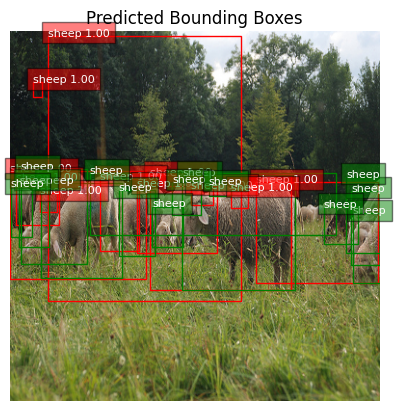

Error processing item 0 in batch: No objects found in XML


Generated text: ['<annotation></annotation>']


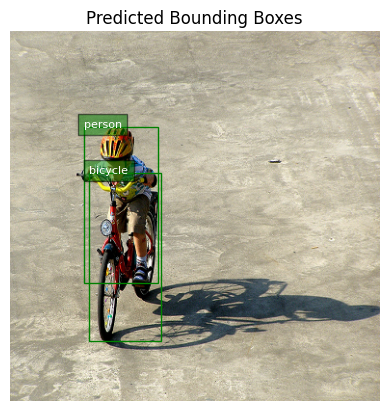

Generated text: ['<annotation><object><class>person</class><bbox><x019/><y149/><x022/><y156/></bbox></object><object><class>kite</class><bbox><x138/><y021/><x192/><y048/></bbox></object></annotation>']


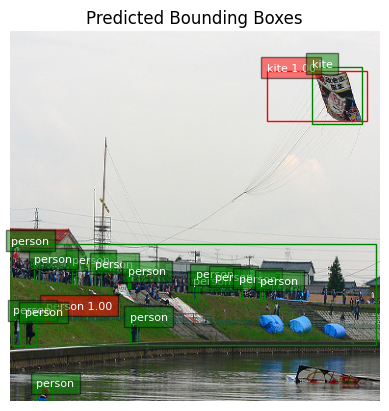

Generated text: ['<annotation><object><class>airplane</class><bbox><x024/><y054/><x192/><y118/></bbox></object></annotation>']


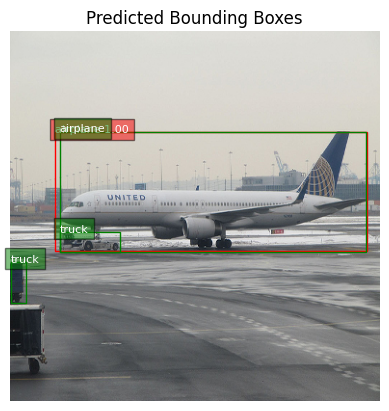

Generated text: ['<annotation><object><class>cell phone</class><bbox><x041/><y011/><x105/><y193/></bbox></object></annotation>']


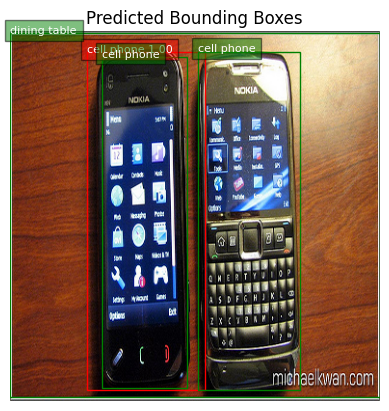

Generated text: ['<annotation><object><class>hot dog</class><bbox><x010/><y083/><x146/><y162/></bbox></object></annotation>']


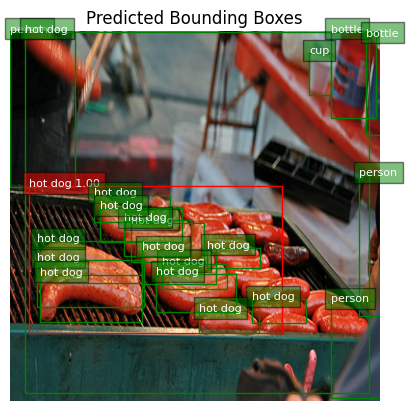

Error processing item 0 in batch: No objects found in XML


Generated text: ['<annotation></annotation>']


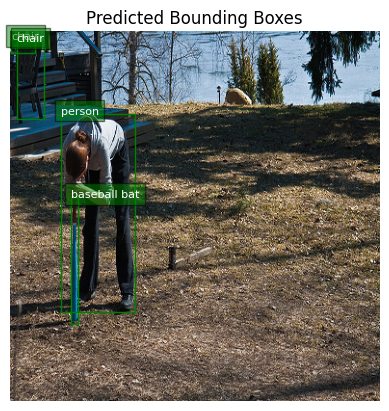

Metrics:
{'map': tensor(0.1310), 'map_50': tensor(0.1590), 'map_75': tensor(0.1206), 'map_small': tensor(0.), 'map_medium': tensor(0.0011), 'map_large': tensor(0.3069), 'mar_1': tensor(0.1294), 'mar_10': tensor(0.1315), 'mar_100': tensor(0.1315), 'mar_small': tensor(0.), 'mar_medium': tensor(0.0010), 'mar_large': tensor(0.3187), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([ 1,  2,  3,  5,  8, 20, 32, 38, 39, 42, 44, 46, 47, 58, 62, 67, 77],
       dtype=torch.int32)}


In [7]:
# Inference Call
from utils.train_utils import JSONStoppingCriteria

print(type(model.model))

for inputs in dataloader:
    inputs = {
        k: v.to(config.device) if torch.is_tensor(v) else v for k, v in inputs.items()
    }
        
    with torch.no_grad(): 
        # Generate outputs using the model
        # Note: Ensure that the model is in eval mode and no gradients are computed
        outputs = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            image=inputs["images"],
            stopping_criteria=[JSONStoppingCriteria(processor.tokenizer)],
            do_sample=True,  # TODO: hardcoded to config
            temperature=0.6,
            top_p=0.9,
            top_k=50,
            image_sizes=inputs["image_sizes"],
            pixel_values=inputs["images"],  # for image_processor in full_detr
            tokenizer=processor.tokenizer,
        )

    # Decode output tokens
    generated_text, predicted_boxes = processor.postprocess_xml_batch(
        outputs,
        dataset=dataloader.dataset,
        device=config.device,
        image_sizes=inputs["image_sizes"],
    )
    target_boxes = processor.postprocess_target_batch(batch=inputs, device=config.device)

    print("Generated text:", generated_text)
    #print("Predicted boxes:", predicted_boxes)
    #print("Target boxes:", target_boxes)

    show_img_with_bbox(inputs["images"][0] , predicted_boxes, target_boxes=target_boxes, title="Predicted Bounding Boxes")

    metrics.update(
        predicted_boxes=predicted_boxes,
        target_boxes=target_boxes,
        generated_text=generated_text,
        target_texts=inputs["bbox_str"],
    )

# Print metrics
print("Metrics:")
print(metrics.metric.compute())


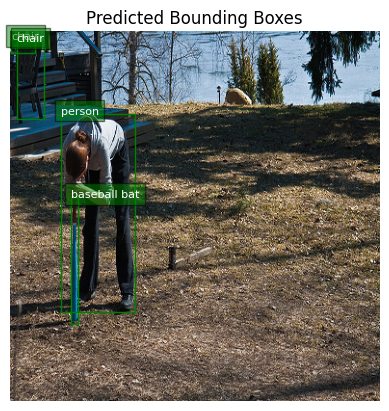

Metrics:
{'map': tensor(0.1310), 'map_50': tensor(0.1590), 'map_75': tensor(0.1206), 'map_small': tensor(0.), 'map_medium': tensor(0.0011), 'map_large': tensor(0.3047), 'mar_1': tensor(0.1293), 'mar_10': tensor(0.1314), 'mar_100': tensor(0.1314), 'mar_small': tensor(0.), 'mar_medium': tensor(0.0010), 'mar_large': tensor(0.3161), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([ 1,  2,  3,  5,  8, 20, 32, 38, 39, 42, 44, 46, 47, 58, 62, 67, 77],
       dtype=torch.int32)}


In [8]:

show_img_with_bbox(inputs["images"][0] , predicted_boxes, target_boxes=target_boxes, title="Predicted Bounding Boxes")


metrics.update(
    predicted_boxes=predicted_boxes,
    target_boxes=target_boxes,
    generated_text=generated_text,
    target_texts=inputs["bbox_str"],
)

print("Metrics:")
print(metrics.metric.compute())
